<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo02_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Processamento e limpeza do dataset

### Iniciando pela configuração do Google Colab

In [11]:
# Instalação de libs que não estão presentes no Colab
!pip install -q emoji
!pip install -q transformers --no-cache-dir
!pip install -q sentencepiece
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 8.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [12]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Importação de bibliotecas utilizadas no pré-processamento
import re
import emoji
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pt_core_news_sm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from IPython.display import display

In [14]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 350)
# configura tema dos gráficos
sns.set_theme(style="whitegrid")
#configura a barra de progressos para usar no apply
tqdm.pandas()
# Identifica device gpu ou cpu disponível
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'

### Carregar arquivo CSV das bases unificadas e validar

In [15]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/datasets_unificados.csv', 
                    sep = ',', names=['texto', 'classe'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   9537 non-null   object
 1   classe  9537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [ ]:
dados[dados['texto'].str.len()<400].sample(n=5)

,texto,classe
8837,"*Reserva de camisas do Mito*\n\nVitor Hugo: 1⃣G 4⃣G\nHorácio: 4⃣G 4⃣M\nJairo: 1 camisa G preta\nDjalma : 3⃣G\nFernando Campelo: 4⃣ GG \nNabell: 1 Branca P\nCarlos Augusto: 1 preta e 1 Branca P\nMarcelo Mesquita: 1 G Branca \nEmerson Souza: 1 GG Branca\nZito: 1 preta e 1 Branca, ambas M\nGilson Batista : Branca G",0
7722,"Você é ADM de vários grupos só porque o máximo de membros no WhatsApp é 256 e isso te irrita?\n\nCansado de usuários que entram no grupo, postam coisas proibidas e saem sem serem punidos?\n\nEstá farto do WhatsApp ou Facebook Messenger?\n\nEntre nesse grupo e se surpreenda 😂😘\nhttps://chat.whatsapp.com/LfiI8FWdomoCdUeH1eZwYQ\n\n*Leia a descrição do grupo*",0
8585,"Lembram da vaia que Roger Waters tomou quando soltou um #elenao? Vejam então a reação da platéia quando a Banda Alemã VoxxClub falou durante uma apresentação na Oktoberfest, a frase: *“Brasil acima de tudo, Deus acima de todos”*... 🇧🇷🇩🇪\n👇🏿👇🏿👇🏿👇🏿👇🏿",1
9147,"No próximo dia 28/10, quando for votar para o segundo turno, caso for com camisa do CURINTIA entregue apenas seu RG ao mesário, e diga que perdeu o título em casa... 😂😂😂😂😂",0
7753,Www.tse.ju.br : Faço campanha de graça para Jair Messias Bolsonaro - Faço campanha de graça para Jair Messias Bolsonaro - https://secure.avaaz.org/po/petition/Wwwtsejubr_Faco_campanha_de_graca_para_Jair_Messias_Bolsonaro/?zXKPSeb,1


### Exploração e limpeza de dados

In [16]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', re.sub('(\n|\r)', ' ', texto))
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Mantem apenas caracteres alfanuméricos com e sem acentuação + pontuação
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = re.sub(r'(\.\.|\.\.\.|\.\.\.\.|\. \.)', '', texto)
    # Remove multiplos caracteres em branco
    return re.sub(r'\s+',' ', texto).strip()

dados["texto_processado"] = dados.texto.progress_apply(limpar_textos)
dados["qtde_palavras"] = dados.texto_processado.apply(
                                lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
display(dados[dados['texto'].str.len()<500].sample(n=5)[['classe', 'texto', 'texto_processado']])

,classe,texto,texto_processado
8743,0,"Ouro Preto ontem, Haddad, Dilma e Pimentel, estava lotado, 🙈 acho que não vai ter segundo turno!","Ouro Preto ontem, Haddad, Dilma e Pimentel, estava lotado, acho que não vai ter segundo turno"
8157,0,"Entrevista da candidata Dilma Rousseff ontem (8/09/2018) em Janaúba ao sr. Ambrósio Prates e jornalista e repórter da Rádio Torre FM 91,7 FM.","Entrevista da candidata Dilma Rousseff ontem 8092018 em Janaúba ao sr. Ambrósio Prates e jornalista e repórter da Rádio Torre FM 91,7 FM."
7655,0,"https://www.oantagonista.com/tv/vazou-propaganda-eleitoral-de-bolsonaro/\n\n\nMuito boa a propaganda eleitoral de Bolsonaro, o video está no antagonista","boa a propaganda eleitoral de Bolsonaro, o video está no antagonista"
7966,0,"Ontem eManaus parou com a grande manifestação da senadora e candidata a reeleição - Vanessa Graziotim - em favor de Lula e do PT. \nVejam o vídeo, é de arrepiar com a multidão!","Ontem eManaus parou com a grande manifestação da senadora e candidata a reeleição - Vanessa Graziotim - em favor de Lula e do PT. Vejam o vídeo, é de arrepiar com a multidão"
8663,1,"De Lavada !!!!\n\nTracking BTG que acabou de sair para o mercado financeiro:\n👉Bolsonaro 77%;\n👇Haddad 23%.\nPS: Votos válidos.\n\nTemos que espalhar ao máximo, pois os institutos de pesquisas podem começar a divulgar as “falsas”pesquisas onde H...","De Lavada Tracking BTG que acabou de sair para o mercado financeiro:Bolsonaro 77Haddad 23.PS: Votos válidos.Temos que espalhar ao máximo, pois os institutos de pesquisas podem começar a divulgar as falsaspesquisas onde Haddad já se aproxima de Bo..."


### Carga da spaCy para limpeza de dados

Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)  
Remove stopworks, mas a pontuação é mantida pois é relevante para o modelo.

In [17]:
nlp = pt_core_news_sm.load()
def limpeza_por_nlp(texto):
  retorno = []
  for token in nlp(texto):                              # tokeniza cada texto
    if len(token.text) > 1 and not token.is_stop:       # se não é um caracter perdido ou stopwords
      if token.pos_ != "NUM":                           # NUM representa numérico no spaCy NER 
        retorno.append(re.sub(r'\d','',token.lemma_))   # Se não for número remove números
      else:
        retorno.append(token.lemma_)                    #lematiza o texto
  return " ".join(retorno)
dados["texto_lematizado"] = dados.texto_processado.progress_apply(limpeza_por_nlp)
dados["qtde_lematizado"] = dados.texto_lematizado.apply(
    lambda texto: len(re.findall(r"[\w']+", texto)))
dados.drop('texto_processado', axis=1, inplace=True)

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
display(dados[dados['texto'].str.len()<500].sample(n=5)[['classe', 'qtde_palavras', 'qtde_lematizado', 'texto_processado', 'texto_lematizado']])

,classe,qtde_palavras,qtde_lematizado,texto_processado,texto_lematizado
8564,1,36,20,"QUE PORCARIA DE OBRA FIZERAM Transposição do Rio São Francisco, 5 cm de cimento com um plástico por baixo. Viva Lula, Viva Dilma. Orgulho de uma nação. A OBRA DO SÉCULO. SERÁ A GLOBO VAI PASSAR",PORCARIA OBRA FIZERAM Transposição Rio Francisco cm cimento plástico viva Lula Viva Dilma orgulho nação OBRA SÉCULO SERÁ GLOBO PASSAR
8381,1,82,35,"É graças aos soldados, e não aos sacerdotes, que podemos ter a religião que desejamos. É graças aos soldados, e não aos jornalistas, que temos a liberdade de imprensa. É graças aos soldados, e não aos poetas, que podemos falar em público. É graças aos soldados, e não aos professores, que existe liberdade de ensino. É graças aos soldados, e não ...",graças soldado sacerdote poder religião desejar graças soldado jornalista liberdade imprensa graças soldado poeta poder falar público graças soldado professor existir liberdade ensino graças soldado advogado existir direito julgamento justo graças soldado político poder votar
7761,1,54,30,"IMPORTANTÍSSIMO Caso o Bolsonaro não ganhe por causa de fraude: Pegue seu comprovante de votação, e coloque o número 17, nele contém seu número de inscrição. Tire uma foto, e envie para o Bolsonaro dep.jairbolsonarocamara.leg.br Terminaremos assim com a fraude nesse país Temos que mandar rápido para todos nossos contatos. VIRALIZEM",IMPORTANTÍSSIMO caso Bolsonaro ganhar causa fraude Pegue comprovante votação coloque 17 em ele contém inscrição Tire foto enviar Bolsonaro dep.jairbolsonarocamara.leg.br Terminaremos fraude país mandar rápido contato VIRALIZEM
8086,1,30,14,"Sem palavras, só divulgue para seus contatos e peçam para que todos façam o mesmo simultaneamente e daqui um minuto está mensagem estará nos quatros cantos da terra. Fora PT",palavra divulgue contato peçar façam simultaneamente de aqui minuto mensagem quatro canto terra PT
5283,1,72,46,"Corpo de Bombeiros confirma: Morre Teori Zavascki O Corpo de Bombeiros confirmou: O ministro Teori Zavascki 68 anos, relator da Lava-Jato, morreu vítima do acidente com o avião que caiu no mar em Paraty. Teori será velado no STF e depois enterrado em Santa Catarina, informou a Veja. O avião modelo Beechcraft C90GT, pertencente ao dono do Hotel ...",corpo Bombeiros confirmar Morre Teori Zavascki Corpo Bombeiros confirmar ministro Teori Zavascki 68 ano relator Lava-Jato morrer vítima acidente avião cair mar Paraty Teori ser velar STF enterrar Santa Catarina informar avião modelo Beechcraft CGT pertencente dono Hotel Emiliano SP RJ ocupante aeronave resistir queda


### O modelo BERTimbau é sensível ao CASE, precisa ser tratado 

In [18]:
# Remove linhas com mais de 10% de palavras em maiúsculo
antes = dados.shape[0]
dados['qtde_maiusculas'] = dados.texto_lematizado.apply(
    lambda texto: len(re.findall("[A-Z][A-Z\d]+", texto)))
dados = dados[(dados['qtde_maiusculas'] / dados["qtde_lematizado"])<0.1].copy()
# Das linhas que ficaram, capitaliza somente as palavras em MAIÚSCULO
dados['texto_lematizado'] = dados.texto_lematizado.apply(
    lambda texto: re.sub("[A-Z][A-Z\d]+", 
    lambda grupo: grupo.group(0).capitalize(), texto))
dados.drop('qtde_maiusculas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}," +
        f" removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 9537, depois: 8785, removido: 752'

### Remover duplicatas (deveria estar marcado como viral na origem)

In [19]:
# Primeiramente remove duplicatas absolutas do texto
antes = dados.shape[0]
dados = dados.drop_duplicates(subset=['texto_lematizado'])
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8785, depois: 8612, removido: 173'

### Remover linhas com mais de 50% das palavras iguais, quando menos de 100 palavras.

In [20]:
dados_menos_100_palavras = dados[dados["qtde_lematizado"]<100].copy()

# Calcula quantidade de palavras duplicadas
def confere_duplicidade(coluna_busca):
  conjunto_palavras = set(re.findall(r"[\w']+", coluna_busca))
  dados_sem_busca = dados_menos_100_palavras.drop(dados.index[dados['texto_lematizado'] == coluna_busca]).copy()
  dados_sem_busca['duplicado_corrente'] = dados_sem_busca.texto_lematizado.apply(
      lambda texto: len(conjunto_palavras.intersection(set(re.findall(r"[\w']+", texto)))))
  return int(dados_sem_busca['duplicado_corrente'].max())

dados['qtde_palavras_duplicadas'] = dados[dados["qtde_lematizado"]<100].texto_lematizado.progress_apply(confere_duplicidade)
dados_menos_100_palavras = pd.DataFrame() #libera área
antes = dados.shape[0]
dados = dados[((dados['qtde_palavras_duplicadas'] / dados["qtde_lematizado"])<0.5) | (dados['qtde_palavras_duplicadas'].isnull())].copy()
dados.drop('qtde_palavras_duplicadas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

  0%|          | 0/3339 [00:00<?, ?it/s]

'Qtde linhas antes: 8612, depois: 7769, removido: 843'

## Confere a distribuição de palavras nas classes

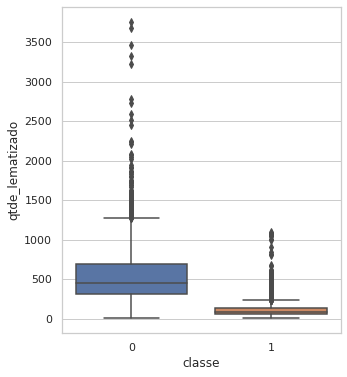

In [21]:
ax, fig = plt.subplots(figsize=[5,6])
ax = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])

In [22]:
def grafico_distribuicao(dfplot):
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 2000, 100)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.countplot(x="classe", data=dados)
  axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
  axes2.set_title('Distribuição de classes', fontsize=14)
  axes2.set_ylabel('quantidade')

[0, 1]

[3815, 3954]

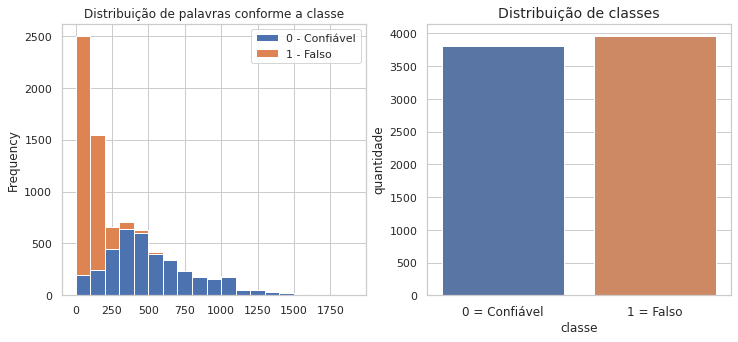

In [23]:
grafico_distribuicao(dados.pivot(columns='classe').qtde_lematizado)
distribuicao = dados.groupby('classe').qtde_lematizado.count()
display(distribuicao.index.to_list(), distribuicao.to_list())

In [24]:
antes = dados.shape[0]
dados = dados.query(
    'qtde_lematizado >= 50 and qtde_lematizado <= 2000'
)
display(f"Qtde antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")
display(f"Maximo de palavras: {dados['qtde_lematizado'].max()}", f"Mínimo de palavras: {dados['qtde_lematizado'].min()}")

'Qtde antes: 7769, depois: 7052, removido: 717'

'Maximo de palavras: 1944'

'Mínimo de palavras: 50'

### Carrega o modelo pré-treinado de sumarização

In [61]:
model_name = "seidel/plsum-base-ptt5" #"csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_pt = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(
      device_disponivel
  )

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

### Separação e salvamento do processo parcial antes de rodar o modelo que leva algumas horas

In [38]:
# Divide o dataframe para executar o modelo somente nos textos grandes e salvar parte do trabalho devido a quedas pela demora
df_menor, df_maior = dados.query('qtde_lematizado <= 300').copy(), dados.query('qtde_lematizado > 300').copy()

# Salva novamente os dados para uso no notebook do próximo passo.
df_menor.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_menor.csv', sep = ',', index=False)
df_maior.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_maior.csv', sep = ',', index=False)

display(f"Menor: {df_menor.shape[0]}; Maior: {df_maior.shape[0]}")

'Menor: 4006; Maior: 3046'

### Principal método que gera os tokens, sumariza e transforma os tokens de volta em palavras

In [62]:
def resumir_textos(texto):
  input_ids = tokenizer(      # tokeniza o texto
      [texto],
      return_tensors="pt",    # retorna o tensores pytorch
      max_length=1500,        # tamanho máximo de entrada
      truncation=True         # caso exceder, trunca, já limitei
  )["input_ids"]
  t_tokens = input_ids.to(device_disponivel) # envia tokens para GPU
  output_ids = model_pt.generate(   # gera tokens de sumarização
      input_ids=t_tokens,   # tokens de entrada
      max_length=300,       # tamanho máximo
      min_length=50,       # tamanho mínimo
      no_repeat_ngram_size=2, # relação de n-grans que não deve repetir
      length_penalty=1.5,   # penalti por tamanho, maior que 1 para tentar atingir próximo ao max_len
      num_beams=4,          # valor para a fórmula do algoritmo de pesquisa heurística
  )[0]
  resumo = tokenizer.decode(  # decodifica a saída do modelo (converter tokens numéricos para texto)
      output_ids,
      skip_special_tokens=True,
      clean_up_tokenization_spaces=False
  )
  return resumo

In [22]:
df_maior["texto_resumido"] = df_maior['texto_lematizado'].progress_apply(resumir_textos)
df_maior["qtde_lematizado"] = df_maior.texto_resumido.apply(
    lambda texto: len(re.findall(r"[\w']+", texto))
)

  0%|          | 0/3368 [00:00<?, ?it/s]

In [23]:
df_maior.drop("texto_lematizado", axis=1, inplace=True)
df_maior.rename(columns = {'texto_resumido':'texto_lematizado'}, inplace = True)

dados = pd.concat(
    [df_menor, df_maior],
    ignore_index=True,
    copy=True,
)

### Plota novamente para ver como ficou

In [24]:
def grafico_distribuicao_boxplot(dados):
  dfplot = dados.pivot(columns='classe').qtde_lematizado
  dfplot.columns = ['0 - Confiável', '1 - Falso']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  axes1 = dfplot.plot(
      ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 280, 30)), 
      title="Distribuição de palavras conforme a classe")
  axes2 = sns.boxplot(y=dados["qtde_lematizado"],x=dados["classe"])
  axes2.set_ylabel('Qtde_Palavras')  

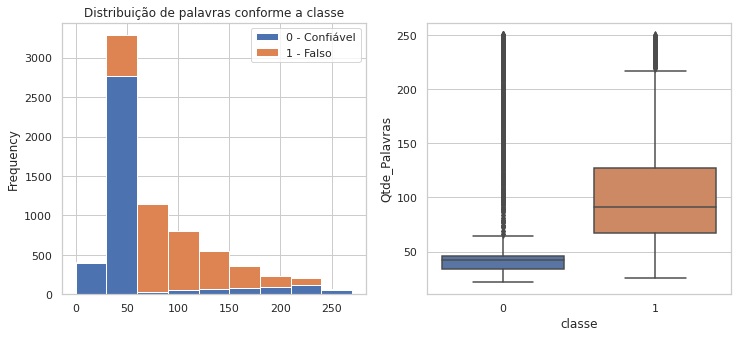

In [25]:
grafico_distribuicao_boxplot(dados)

### Salva resultado para usar na exploração

In [26]:
# Salva novamente os dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',', index=False)